# ARIMA 모델을 활용한 테슬라 주식 예측

### ARIMA = AR(Autoregressive) + I(Integrated) + MA(Moving Average) 


### 루브릭
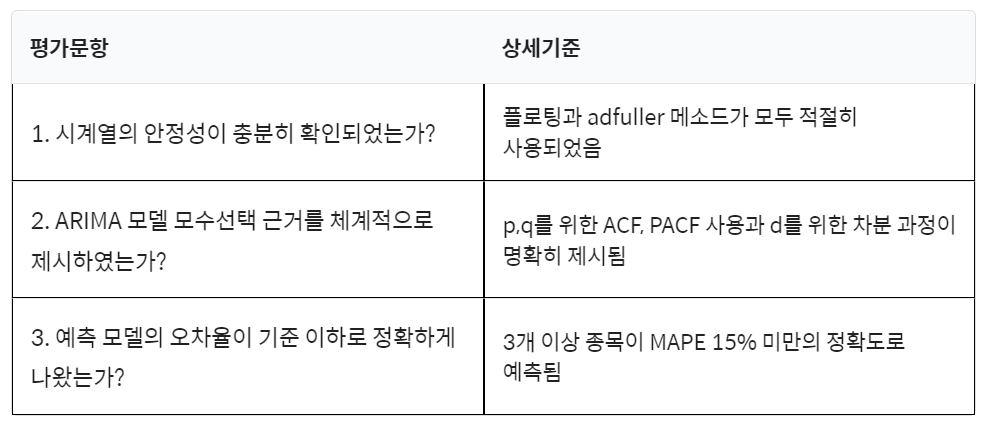

### 개념 정리

- 이동평균 : 일반 평균과는 다르게 일정한 크기의 한정되어 있는 수 집합의 모든 값을 대상으로 부분집합을 평균계산에 활용한다는 특징이 있음.
또한 이 부분집합을 이동시키며 연속적인 평균값을 산출함으로써 평균값의 흐름을 알 수 있으며, 일정 기간 혹은 데이터 구간의 평균의 흐름을 알 수 있게 해줌.

    
- 통계적 가설 검정

- P검정시 고정시키는 α 값은 학문 분야에 따라서 다른데 사회과학 분야는 보통 0.05, 자연 과학 분야는 0.01이라는 가이드라인을 제시

(1) 귀무가설 : 통계학에서 처음부터 버릴 것을 예상하는 가설,차이가 없거나 의미있는 차이가 없는 경우의 가설이며 이것이 맞거나 맞지 않다는 통계학적 증거를 통해 증명하려는 가설
ex) 남학생의 평균 키가 170cm라는 주장을 통계적으로 검정한다면, 이에 대한 귀무 가설은 “전국 남학생의 평균 키는 170cm과 같다.(또는 차이가 없다.)”

(2) 대립 :귀무가설이 틀렸다고 판단했을 때(기각되었을 때), 대안적으로 선택하는(채택되는) 가설"가설 :귀무가설이 틀렸다고 판단했을 때(기각되었을 때), 대안적으로 선택하는(채택되는) 가설"
ex) 남학생의 평균 키가 170cm라는 주장을 통계적으로 검정한다면, 이에 대한 대립 가설은 “전국 남학생의 평균 키는 170cm와 다르다.(또는 차이가 있다.)

(3) P-value :“귀무가설이 참이라고 가정했을 때, 표본으로 얻어지는 통계치(예: 표본 평균)가 나타날 확률"
ex) p값이 낮다는 것은 귀무가설이 참이라는 가정 하에서 표본을 추출했을 때, 이런 표본 평균이 관측될 확률이 낮다는 것을 뜻

->즉 p 값이 0.05으로 미만 매우 낮으면, 이러한 표본 통계량은 우연히 나타나기 어려운 케이스이기 때문에, 귀무가설을 채택하지 않고(기각하고), 대안적인 가설, 즉 대립가설을 채택하게 됨.

- ADF Test: ARIMA모형의 적분 차수를 판단하기 위한 검정 방법으로서, 시계열이 안정적(Stationary)인지 여부를 확인하는데 이용되는 방법이기도 함.
-> 적분차수가 1차인 경우가 귀무가설이되며,이 경우 특성 방정식의 해에 x=1, x=1 즉, 단위근이 포함되기 때문에 단위근 검정이라고도함.

- 검정통계량이 Critical Value보다 작거나 p-value가 설정한 유의수준 값보다 작으면 정상적인 시계열 데이터임

## STEP 1  : 라이브러리 Import 및 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    804.820007
2021-02-11    811.659973
2021-02-12    816.119995
2021-02-16    796.219971
2021-02-17    798.150024
Name: Close, dtype: float64

칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있음.

종가(Close)만 사용할려고 함.

## STEP 2 : 각종 전처리 수행

#### 결측치 확인

In [2]:
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

#### 결측치 처리방법

- 결측치가 있는 데이터를 모두 삭제(drop)

- 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입
ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

- 하지만 시계열 데이터는 보간 하는 방법이 적절함
ex) 아래 참고

In [3]:
# # 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
# ts=ts.interpolate(method='time')

# # 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
# print(ts[ts1.isna()])

# # 다시 그래프를 확인해봅시다!
# plt.plot(ts)

##### 로그 변환 시도 

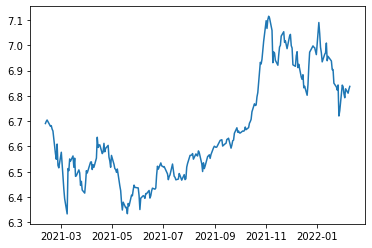

In [4]:
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

#### 1) 정성적 분석

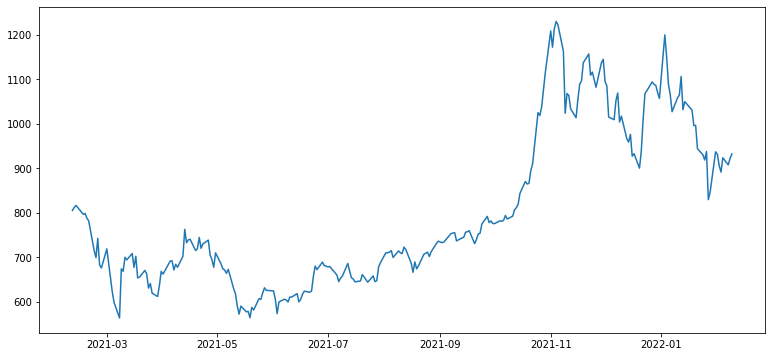

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정.

# 시계열(time series) 데이터를 차트로 그려봄. 
plt.plot(ts)

시간 추이에 따라 일정한 평균, 분산, 자기공분산의 패턴이 나타나는 것 같지 않음.

오히려 21년 9월을 기점으로  분포가 더 커 지는 것이 확인됨.

이에 이동평균을 확인해보기로 함.

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

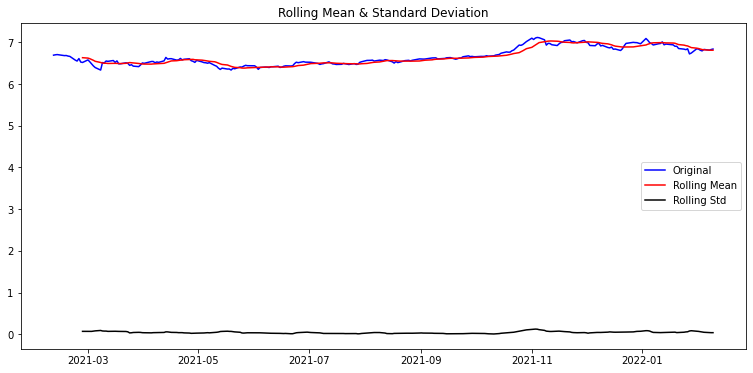

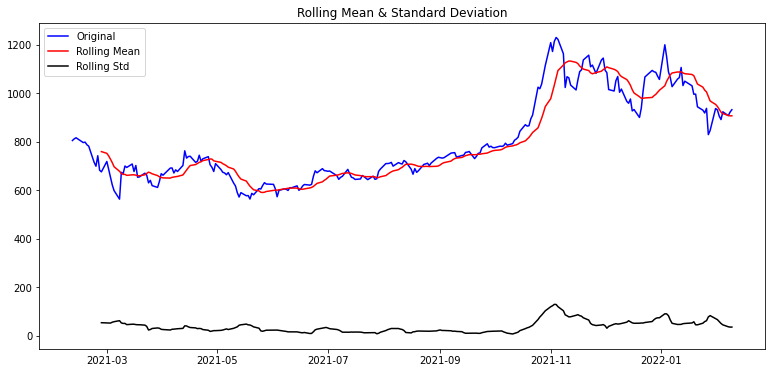

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)
plot_rolling_statistics(ts, window=12)

시각화를 해보았을 때 얼핏 평균과 표준편차값이 비슷해보이며, 시간이 지남에 따라 평균이 우상향 되는 것을 확인함.

시간 추이에 따라 평균과 분산이 증가하는 패턴을 보인다면 불안정에 가깝다고 생각 할 수 있음.

#### 2) 정량적 분석 - Augmented Dickey-Fuller Test

1.주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,

2.통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에

3.이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택

In [8]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.228461
p-value                          0.661234
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


P-value의 값이 0.66으로 기준 알파값 0.05보다 훨씬 높게 나옴. 따라서, 귀무가설은 기각할 수 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없음

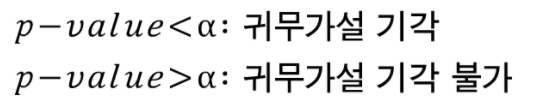

#### 불안정(Non-Stationary) 시계열 데이터를 안정적인 시계열로 바꾸는 방법

1. 시계열 분해(Time series decomposition) 기법을 적용



2. 정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도

- 로그변환 시도(이미 위에서 함)
- 차분(Differencing) - 계절성(Seasonality) 상쇄
- Moving average 제거 - 추세(Trend) 상쇄하기- rolling mean을 구해서 ts_log에서 빼주는 방법

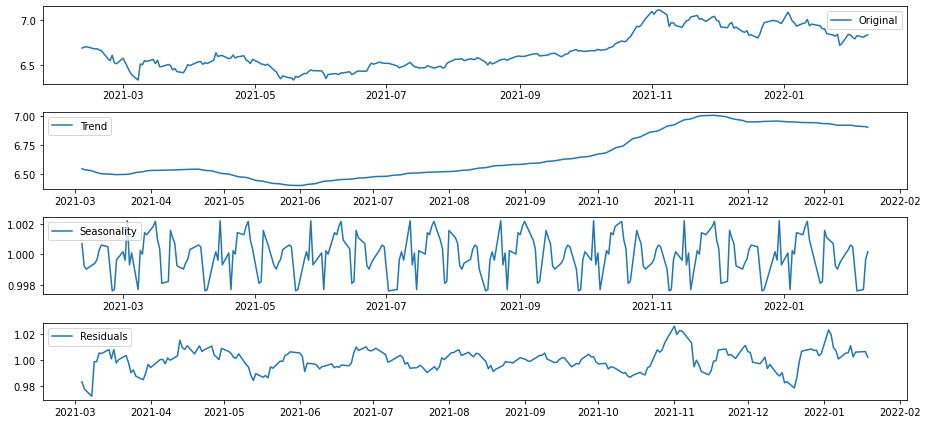

In [10]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


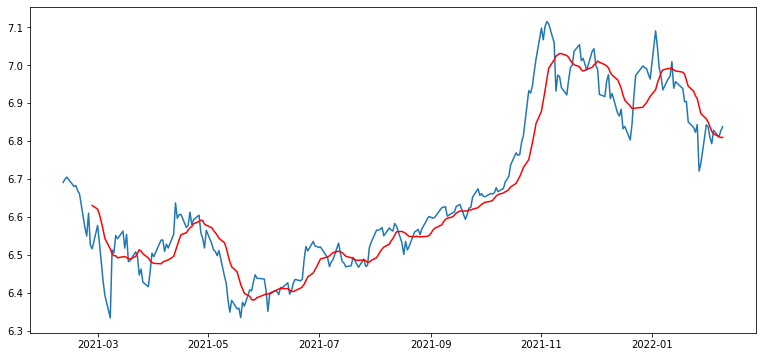

In [11]:
# moving average구하기 

moving_avg = ts_log.rolling(window=12).mean()  
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2021-02-10         NaN
2021-02-11         NaN
2021-02-12         NaN
2021-02-16         NaN
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26   -0.114321
2021-03-01   -0.043243
2021-03-02   -0.074829
2021-03-03   -0.105908
Name: Close, dtype: float64

Moving Average 계산 시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생하여 결측치 제거

In [13]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-02-26   -0.114321
2021-03-01   -0.043243
2021-03-02   -0.074829
2021-03-03   -0.105908
2021-03-04   -0.135099
2021-03-05   -0.149566
2021-03-08   -0.181841
2021-03-09    0.009849
2021-03-10    0.007221
2021-03-11    0.053261
2021-03-12    0.050443
2021-03-15    0.067636
2021-03-16    0.022600
2021-03-17    0.060719
2021-03-18   -0.006980
Name: Close, dtype: float64

다시 ts_log_moving_avg를 정성, 정량적으로 분석

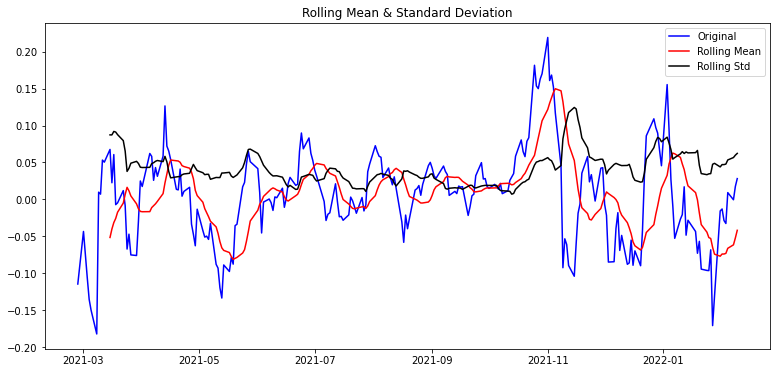

Results of Dickey-Fuller Test:
Test Statistic                  -3.581959
p-value                          0.006115
#Lags Used                      12.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


In [29]:
plot_rolling_statistics(ts_log_moving_avg)
augmented_dickey_fuller_test(ts_log_moving_avg)

p-value의 값이 0.006115로 거의 0에 가깝게 나타남.

p값이 낮다는 것은 귀무가설이 참이라는 가정 하에서 표본을 추출했을 때, 이런 표본 평균이 관측될 확률이 낮다는 것을 뜻함. 즉 p 값이 매우 낮으면, 이러한 표본 통계량은 우연히 나타나기 어려운 케이스이기 때문에, 우리는 귀무가설을 채택하지 않고(기각하고), 대안적인 가설, 즉 이 시계열은 안정적 시계열이라는 대립가설을 채택하게 됨.

### ARIMA 모델 모수 설정

p : 자기회귀 모형(AR)의 시차

d : 차분 누적(I) 횟수

q : 이동평균 모형(MA)의 시차

위의 모수를 결정하는 방법으로, ACF, PACF가 있음.
    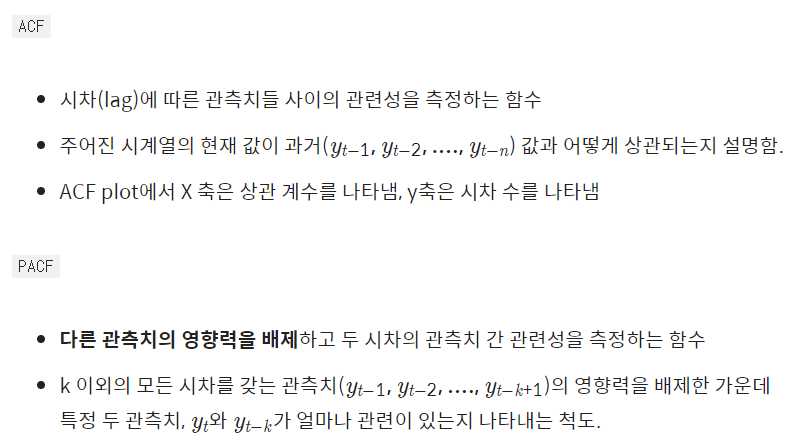
    
    

 statsmodels에서 제공하는 ACF와 PACF 플로팅 기능을 적용함.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


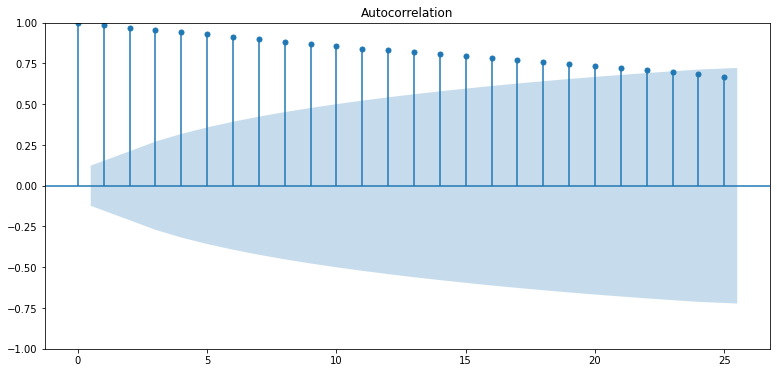

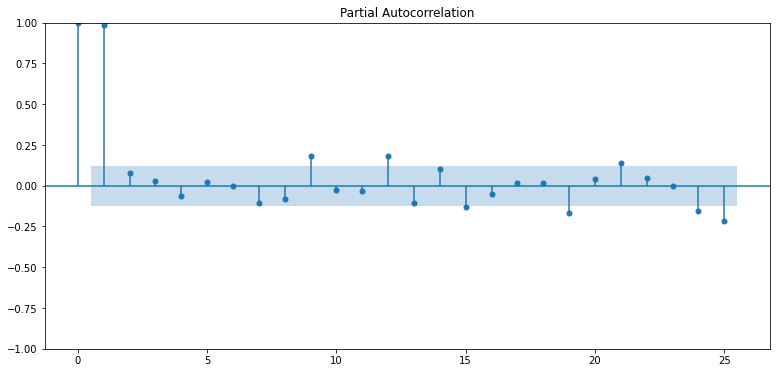

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정함.

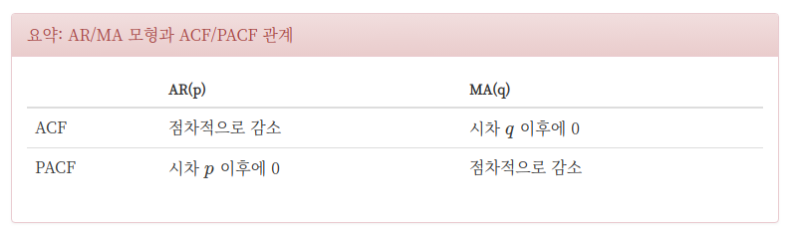

이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 으로 보임.(p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문)

PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻

반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있음. q에 대해서는 적합한 값이 없어 보이므로, MA를 고려할 필요가 없다면 q=0으로 둘 수 있음.

d를 구하기 위해서는, d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 봐야됨.

Results of Dickey-Fuller Test:
Test Statistic                -1.688748e+01
p-value                        1.051349e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


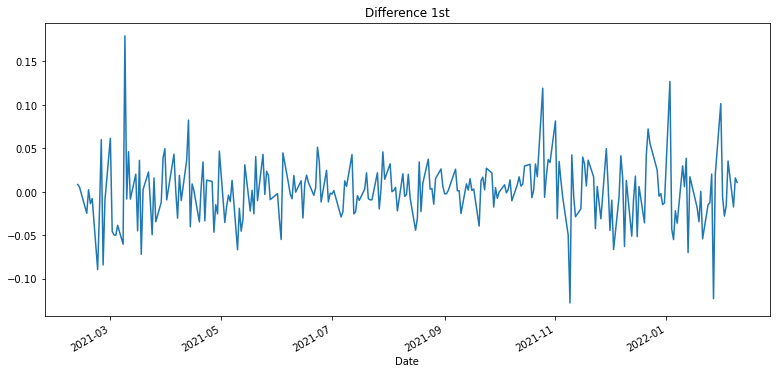

In [16]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.943489e+00
p-value                        1.011002e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


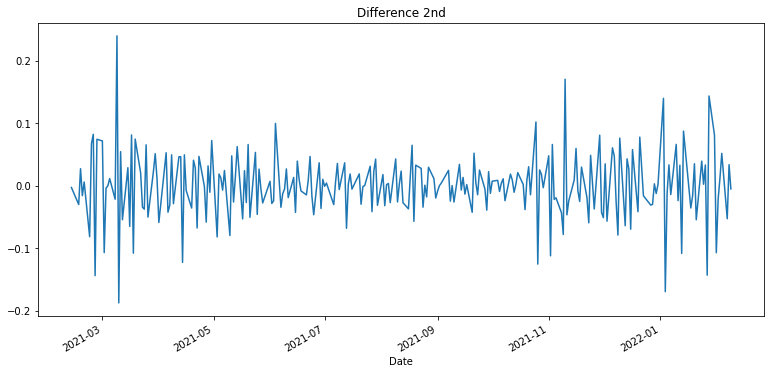

In [17]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분과 2차 차분을 통해 안정화상태를 확인하였을 때 불안정한 모습이 관찰됨.

이에 d 값을 변경하면서 최적의 값을 찾아야됨

## STEP 4 : 학습, 테스트 데이터셋 생성

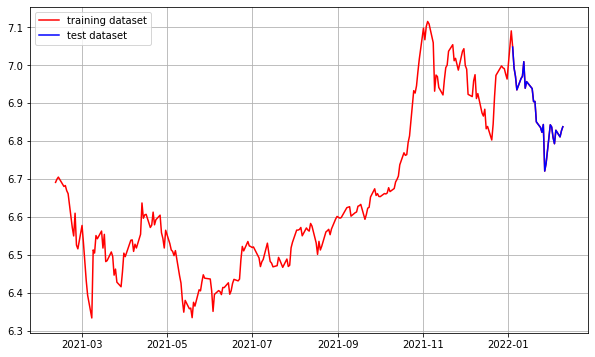

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


## STEP 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


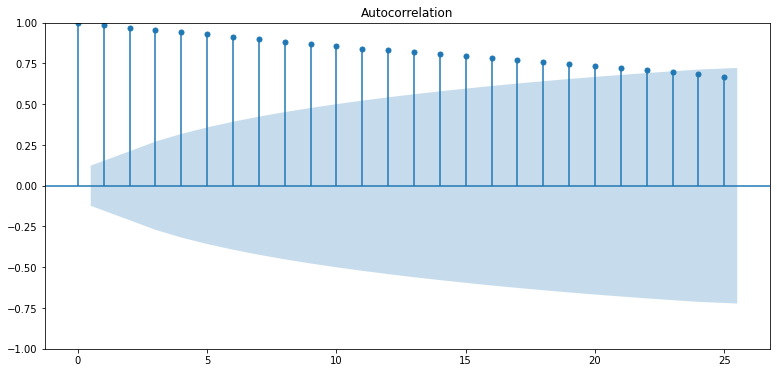

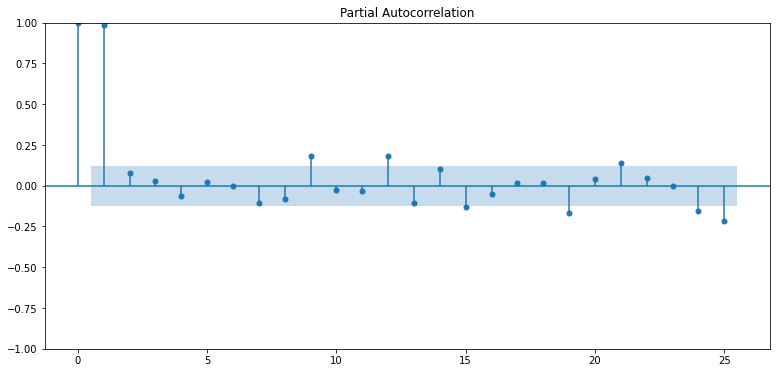

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

#### 차분 안정성 확인

Results of Dickey-Fuller Test:
Test Statistic                -1.688748e+01
p-value                        1.051349e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.943489e+00
p-value                        1.011002e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


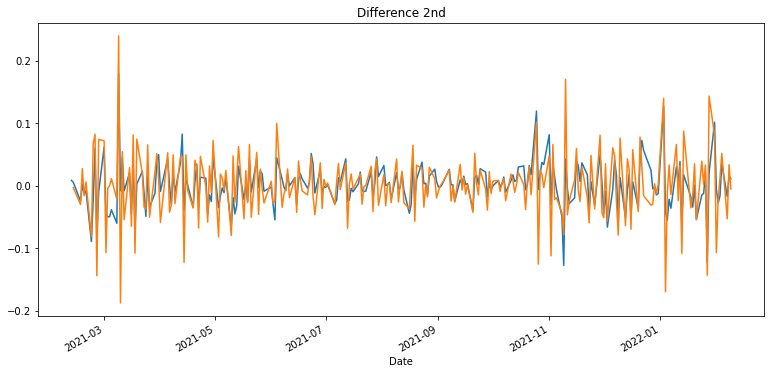

In [27]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [28]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.951004e+00
p-value                        2.147324e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


## STEP 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [22]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 439.894
Date:                Thu, 10 Feb 2022   AIC                           -869.787
Time:                        13:46:34   BIC                           -852.663
Sample:                             0   HQIC                          -862.877
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7461      0.210     32.065      0.000       6.334       7.158
ar.L1          0.4168      1.168      0.357      0.721      -1.872       2.705
ar.L2          0.5661      1.153      0.491      0.6

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


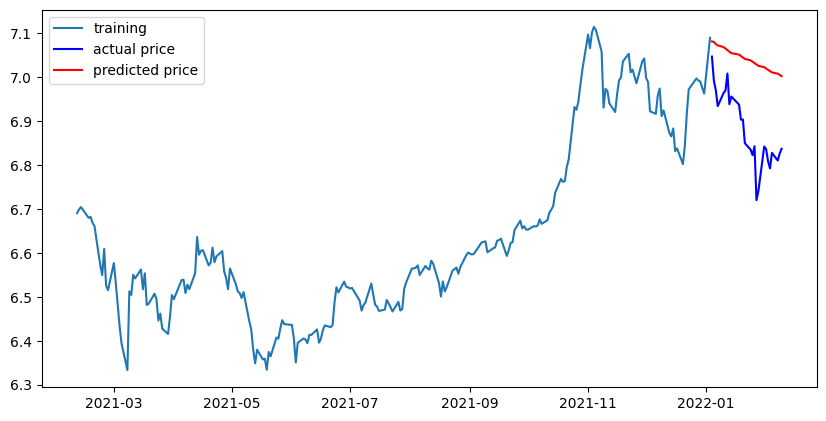

In [23]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  30898.462602270472
MAE:  165.5170851436495
RMSE:  175.7795852830199
MAPE: 17.54%


테슬라 종목의 경우 MAPE 값이 17.54% 정확도로 좋지 않게 나옴. 따라서 다른 종목을 시험해보기로 함. 

## STEP 7 : 다른 주식 종목 예측해 보기

#### (1) 애플

In [30]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    135.389999
2021-02-11    135.130005
2021-02-12    135.369995
2021-02-16    133.190002
2021-02-17    130.839996
Name: Close, dtype: float64

In [31]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [32]:
# 로그 변환 시도 
ts_log = np.log(ts)

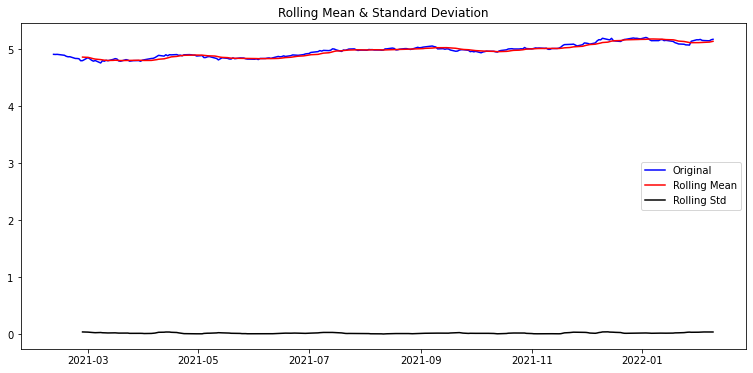

Results of Dickey-Fuller Test:
Test Statistic                  -0.410001
p-value                          0.908416
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


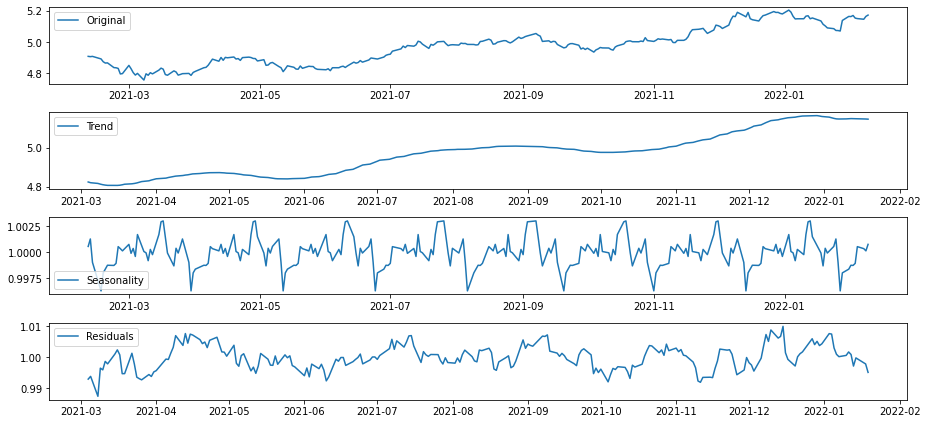

In [33]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [34]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.747775
p-value                          0.000068
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


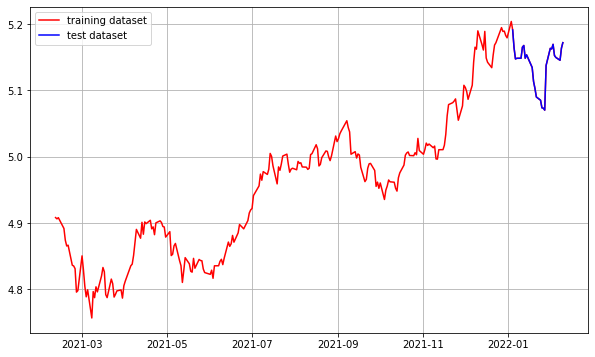

In [35]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


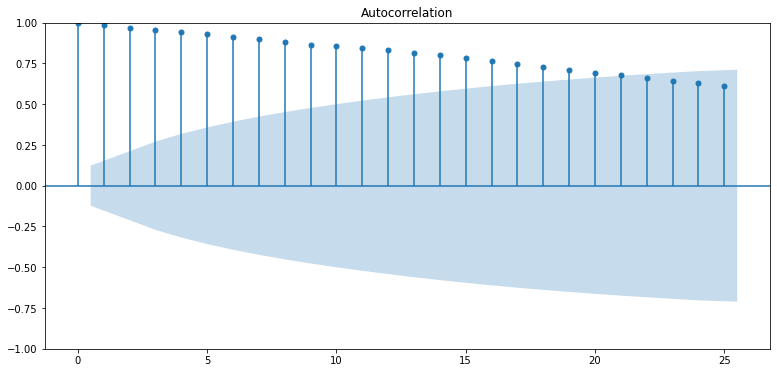

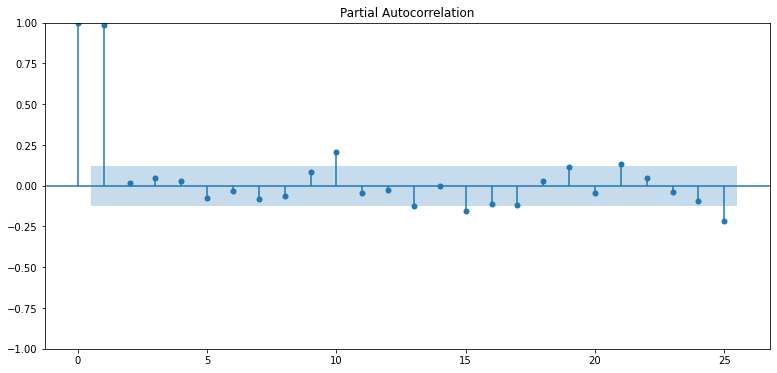

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.969701e+00
p-value                        2.257472e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.667778e+00
p-value                        1.623806e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


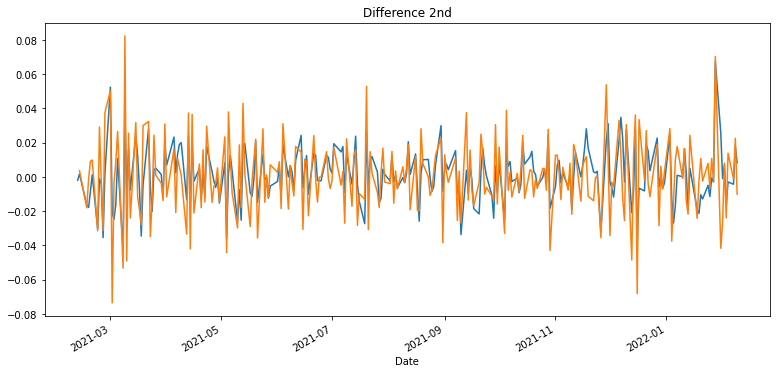

In [37]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [38]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 629.255
Date:                Thu, 10 Feb 2022   AIC                          -1248.511
Time:                        14:13:36   BIC                          -1231.386
Sample:                             0   HQIC                         -1241.601
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0134      0.126     39.731      0.000       4.766       5.261
ar.L1          0.0167      0.040      0.421      0.674      -0.061       0.094
ar.L2          0.9719      0.037     26.372      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


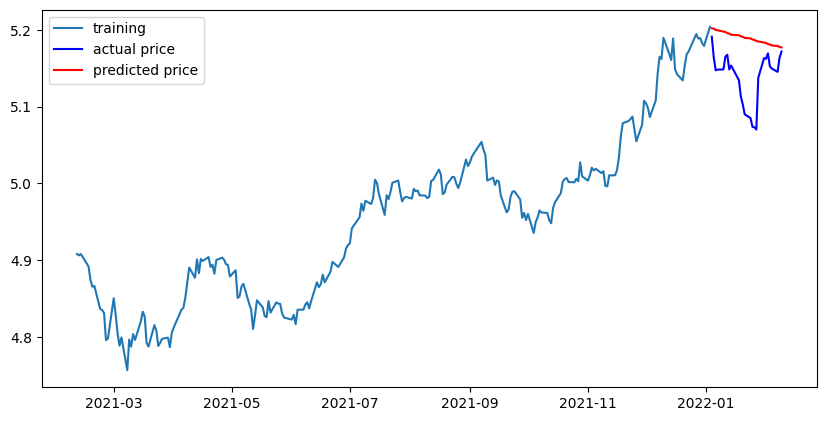

In [39]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  111.7743621461982
MAE:  8.873584507299991
RMSE:  10.572339483113385
MAPE: 5.32%


#### (2) 코카콜라

In [41]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/KO.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    49.599998
2021-02-11    50.299999
2021-02-12    50.689999
2021-02-16    50.270000
2021-02-17    50.130001
Name: Close, dtype: float64

In [42]:
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [43]:
# 로그 변환 시도 
ts_log = np.log(ts)

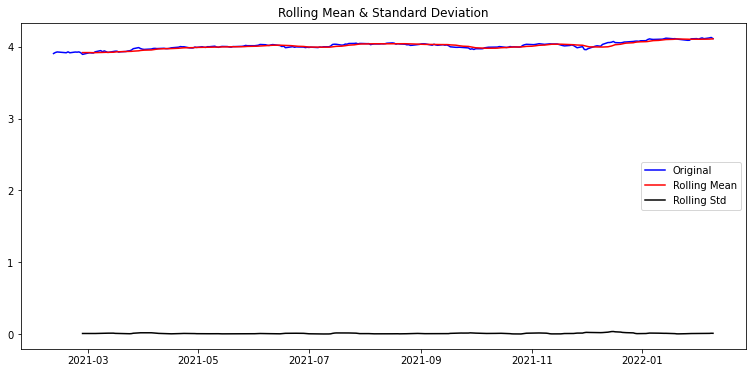

Results of Dickey-Fuller Test:
Test Statistic                  -1.526290
p-value                          0.520468
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


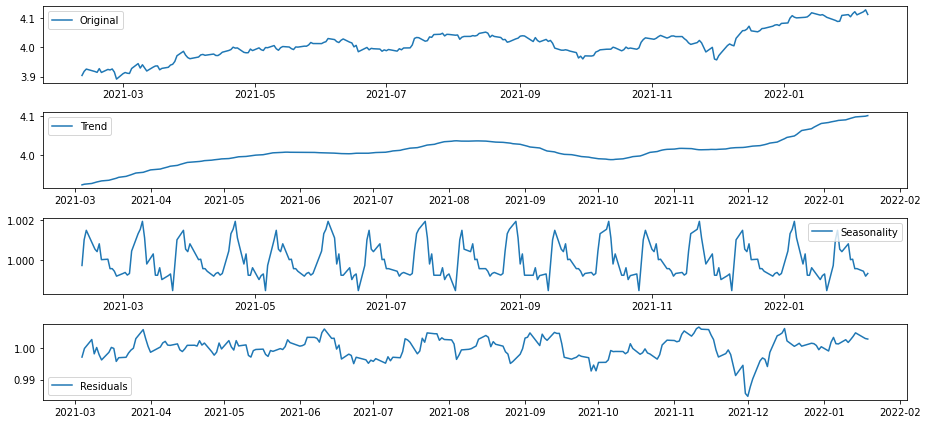

In [44]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [45]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.968589
p-value                          0.001584
#Lags Used                      15.000000
Number of Observations Used    207.000000
Critical Value (1%)             -3.462342
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
dtype: float64


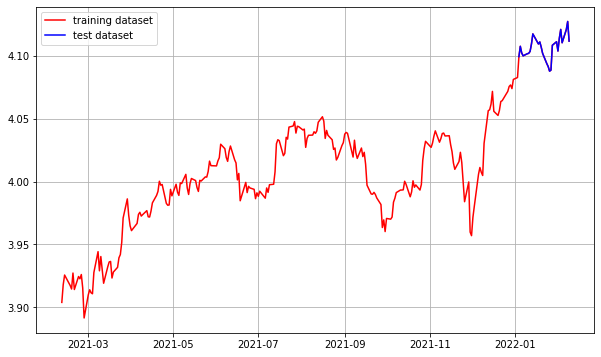

In [46]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


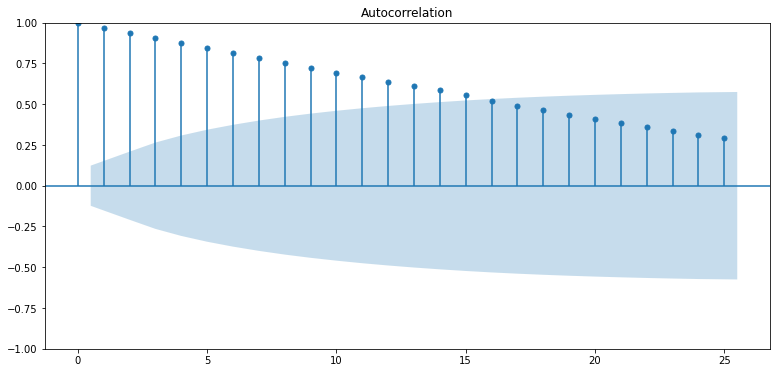

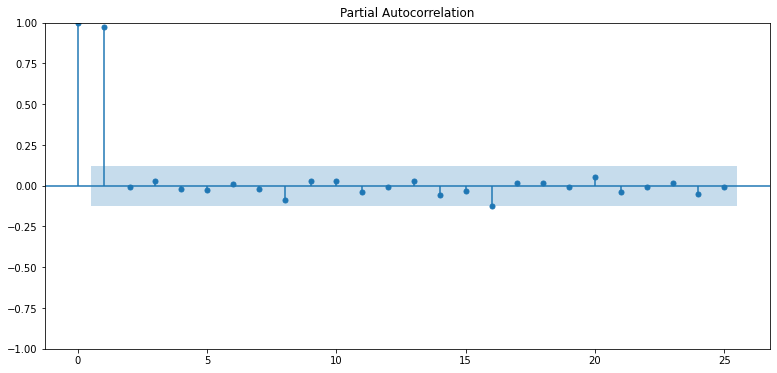

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.625996e+01
p-value                        3.574063e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.829475e+00
p-value                        6.349666e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


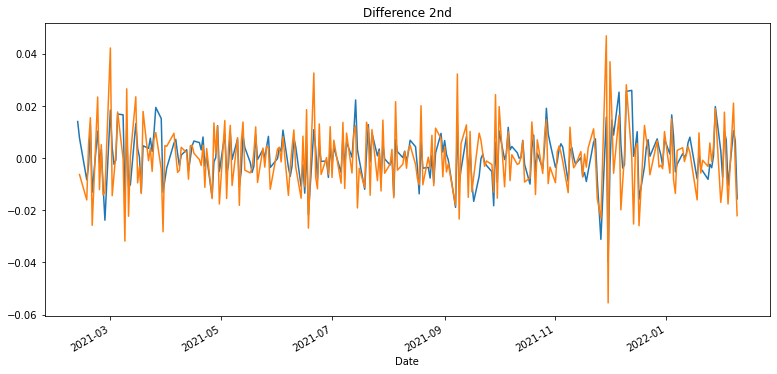

In [48]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [49]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 744.511
Date:                Thu, 10 Feb 2022   AIC                          -1479.022
Time:                        14:18:05   BIC                          -1461.897
Sample:                             0   HQIC                         -1472.112
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9986      0.043     92.766      0.000       3.914       4.083
ar.L1          0.1288      4.455      0.029      0.977      -8.604       8.861
ar.L2          0.8505      4.401      0.193      0.8

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


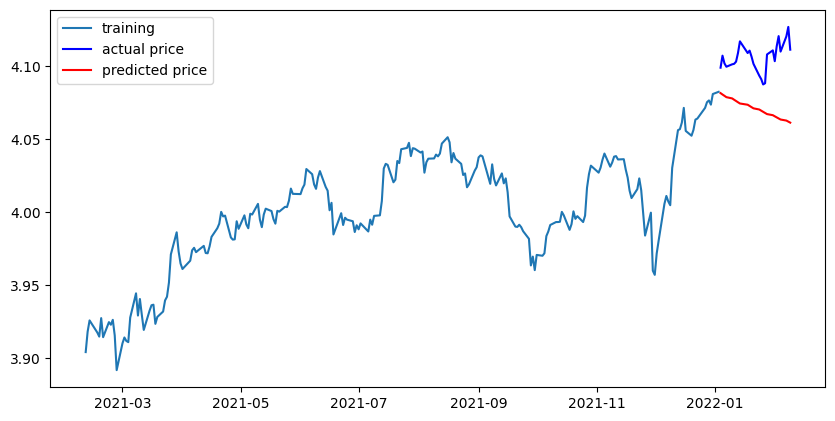

In [50]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4.984319036853476
MAE:  2.0884734966077
RMSE:  2.232558854062637
MAPE: 3.43%


#### (3) 마이크로소프트

In [53]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/MSFT.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    242.820007
2021-02-11    244.490005
2021-02-12    244.990005
2021-02-16    243.699997
2021-02-17    244.199997
Name: Close, dtype: float64

In [54]:
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [55]:
# 로그 변환 시도 
ts_log = np.log(ts)

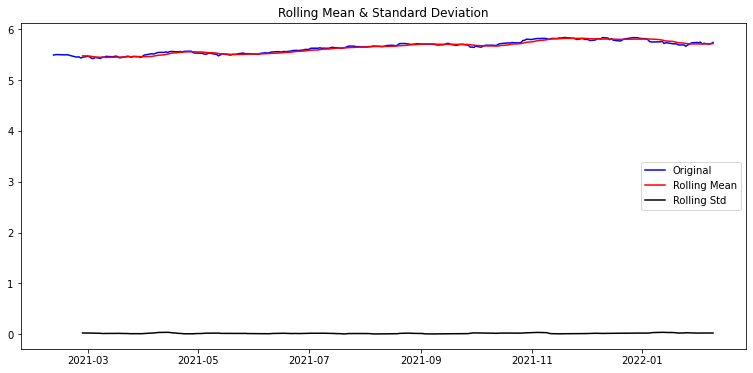

Results of Dickey-Fuller Test:
Test Statistic                  -1.161048
p-value                          0.690124
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


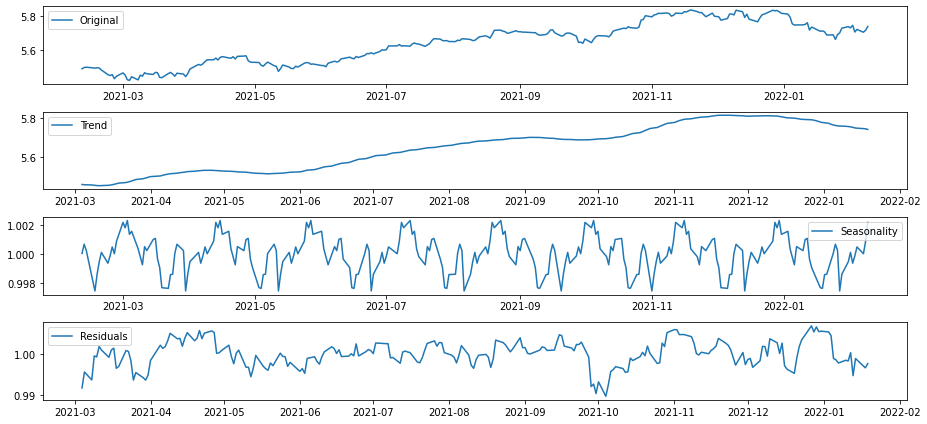

In [56]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [57]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.516229
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


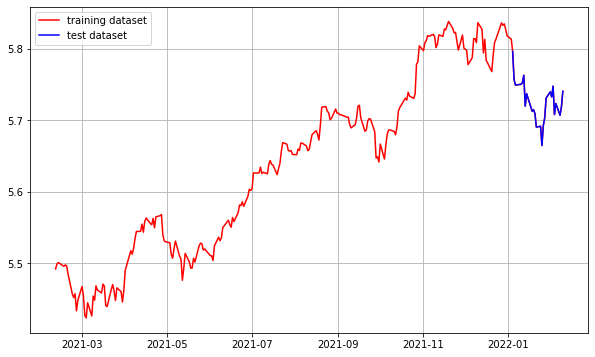

In [58]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


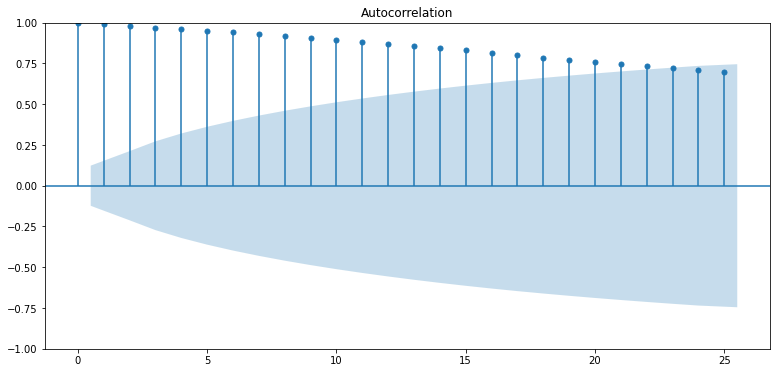

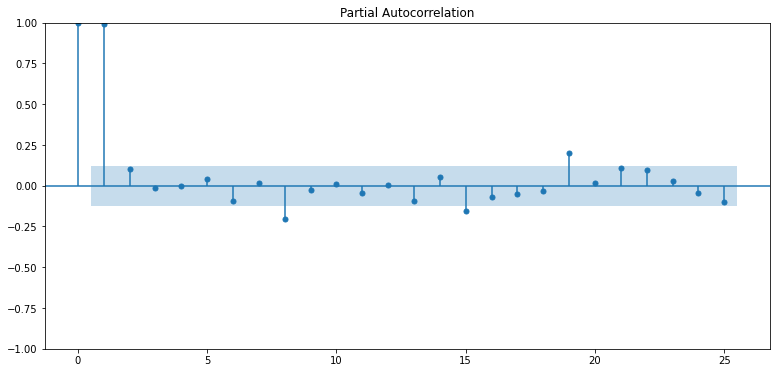

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.659486e+01
p-value                        1.785608e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.319944e+00
p-value                        1.201500e-10
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


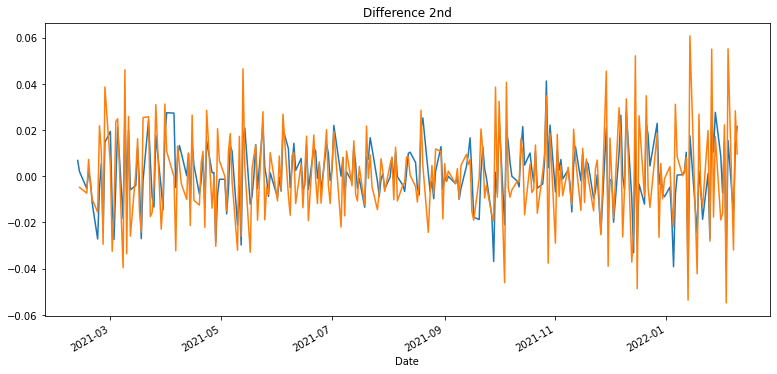

In [60]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [61]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 664.240
Date:                Thu, 10 Feb 2022   AIC                          -1318.481
Time:                        14:23:03   BIC                          -1301.356
Sample:                             0   HQIC                         -1311.571
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6472      0.142     39.824      0.000       5.369       5.925
ar.L1          0.0721      0.264      0.273      0.785      -0.445       0.590
ar.L2          0.9218      0.263      3.511      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


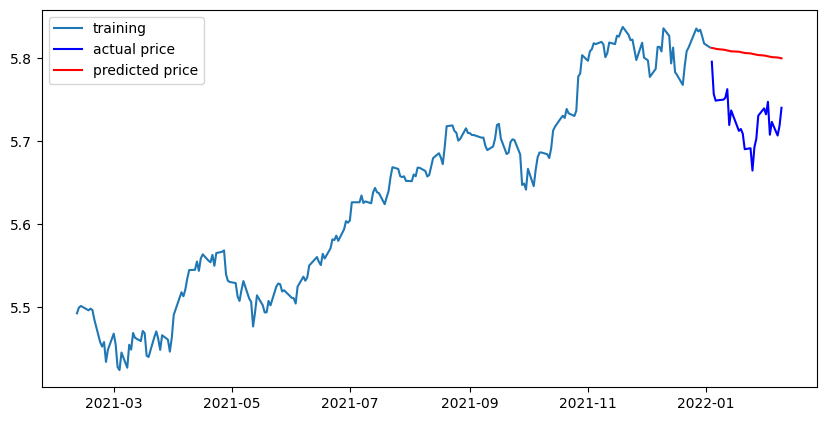

In [62]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  701.6875011382059
MAE:  25.25774262046314
RMSE:  26.48938468779911
MAPE: 8.30%


## Report

ARIMA 모델을 적용하여 대형 주식회사들의 주식을 예측하는 모델을 만들어보았다.

테슬라 : 17.54% / 애플 5.32% / 코카콜라 3.43% / 마이크로소프트 8.30%로 정확도가 예측 되었음.

처음 테슬라 모델을 만들 시, 불안정형에서 안전형 모델로 만들기 위하여 제시된 모든 방안을 적용해보았으나, 오히려 뒤에 방안을 적용했을 시에는 P검증값이 1에 가까워졌음을 확인함. 추측하건데 작년부터 테슬라의 주가변동이 심하여 예측하는 모델을 형성하기가 힘들었지 않나
판단이 되었음.
